# 1. INSTALL REQUIRED LIBRARIES

In [ ]:
!pip install bertopic
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

#2. IMPORT LIBRARIES**


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Libraries untuk text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Libraries untuk BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

# 3. LOAD DATA


In [ ]:
print("📊 Loading data...")
df = pd.read_csv('Sunnah.csv')
print(f"✅ Data loaded successfully!")
print(f"📋 Shape: {df.shape}")
print(f"📑 Columns: {df.columns.tolist()}")

📊 Loading data...
✅ Data loaded successfully!
📋 Shape: (38101, 3)
📑 Columns: ['Perawi', 'Arab', 'Terjemahan']


# 4. EXPLORATORY DATA ANALYSIS (EDA)


In [ ]:
print("\n" + "="*50)
print("📈 EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic info
print(f"📊 Dataset Info:")
print(f"   - Total hadits: {len(df):,}")
print(f"   - Missing values per column:")
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f"     {col}: {missing:,} ({missing/len(df)*100:.1f}%)")

# Sample data
print(f"\n📖 Sample hadits:")
for i in range(3):
    print(f"\n{i+1}. Perawi: {df.iloc[i]['Perawi']}")
    print(f"   Terjemahan: {df.iloc[i]['Terjemahan'][:100]}...")


📈 EXPLORATORY DATA ANALYSIS
📊 Dataset Info:
   - Total hadits: 38,101
   - Missing values per column:
     Perawi: 1 (0.0%)
     Arab: 1 (0.0%)
     Terjemahan: 1 (0.0%)

📖 Sample hadits:

1. Perawi: Hadits Abu Daud Nomor 1
   Terjemahan: Telah menceritakan kepada kami [Abdullah bin Maslamah bin Qa'nab al Qa'nabi] telah menceritakan kepa...

2. Perawi: Hadits Abu Daud Nomor 2
   Terjemahan: Telah menceritakan kepada kami [Musaddad bin Musarhad] telah menceritakan kepada kami [Isa bin Yunus...

3. Perawi: Hadits Abu Daud Nomor 3
   Terjemahan: Telah menceritakan kepada kami [Musa bin Isma'il] telah menceritakan kepada kami [Hammad] telah meng...


**DATA CLEANING FUNCTION**


In [ ]:
def clean_indonesian_text(text):
    """
    Fungsi untuk membersihkan teks hadits bahasa Indonesia
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove brackets and their contents (seperti [nama perawi])
    text = re.sub(r'\[.*?\]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading/trailing whitespace
    text = text.strip()

    return text

def remove_indonesian_stopwords(text):
    """
    Fungsi untuk menghapus stopwords bahasa Indonesia
    """
    # Stopwords bahasa Indonesia yang umum dalam hadits
    indonesian_stopwords = [
        'telah', 'menceritakan', 'kepada', 'kami', 'dari', 'bin', 'ibn', 'abu',
        'yang', 'dan', 'adalah', 'dengan', 'untuk', 'dalam', 'pada', 'itu',
        'ini', 'dia', 'mereka', 'kita', 'saya', 'aku', 'engkau', 'kamu',
        'beliau', 'ia', 'nya', 'juga', 'akan', 'telah', 'sudah', 'sedang',
        'bahwa', 'jika', 'apabila', 'ketika', 'saat', 'waktu', 'kemudian',
        'lalu', 'maka', 'sehingga', 'hingga', 'sampai', 'atau', 'tetapi',
        'namun', 'karena', 'sebab', 'oleh', 'bagi', 'tentang', 'mengenai',
        'terhadap', 'atas', 'bawah', 'depan', 'belakang', 'kiri', 'kanan'
    ]

    words = text.split()
    filtered_words = [word for word in words if word not in indonesian_stopwords]
    return ' '.join(filtered_words)

**APPLY CLEANING**


In [ ]:
print("\n" + "="*50)
print("🧹 DATA CLEANING")
print("="*50)

print("📝 Cleaning text...")
# Clean terjemahan column
df['cleaned_text'] = df['Terjemahan'].apply(clean_indonesian_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_indonesian_stopwords)

# Remove empty texts
df = df[df['cleaned_text'].str.len() > 10].reset_index(drop=True)

print(f"✅ Cleaning completed!")
print(f"📊 After cleaning: {len(df):,} hadits")

# Show cleaning results
print(f"\n📖 Sample cleaned text:")
for i in range(3):
    print(f"\n{i+1}. Original: {df.iloc[i]['Terjemahan'][:100]}...")
    print(f"   Cleaned:  {df.iloc[i]['cleaned_text'][:100]}...")



🧹 DATA CLEANING
📝 Cleaning text...
✅ Cleaning completed!
📊 After cleaning: 38,100 hadits

📖 Sample cleaned text:

1. Original: Telah menceritakan kepada kami [Abdullah bin Maslamah bin Qa'nab al Qa'nabi] telah menceritakan kepa...
   Cleaned:  bahwasanya nabi shallallahu 'alaihi wasallam hendak pergi buang hajat, menjauh....

2. Original: Telah menceritakan kepada kami [Musaddad bin Musarhad] telah menceritakan kepada kami [Isa bin Yunus...
   Cleaned:  mengabarkan bahwasanya nabi shallallahu 'alaihi wasallam hendak buang hajat, pergi tidak ada seorang...

3. Original: Telah menceritakan kepada kami [Musa bin Isma'il] telah menceritakan kepada kami [Hammad] telah meng...
   Cleaned:  mengabarkan berkata; berkata; tatkala abdullah abbas datang ke bashrah, hadits , abdullah menulis su...


TEXT LENGTH ANALYSIS



📏 TEXT LENGTH ANALYSIS
📊 Text Statistics:
   - Average text length: 445 characters
   - Average word count: 55 words
   - Min word count: 2
   - Max word count: 1665


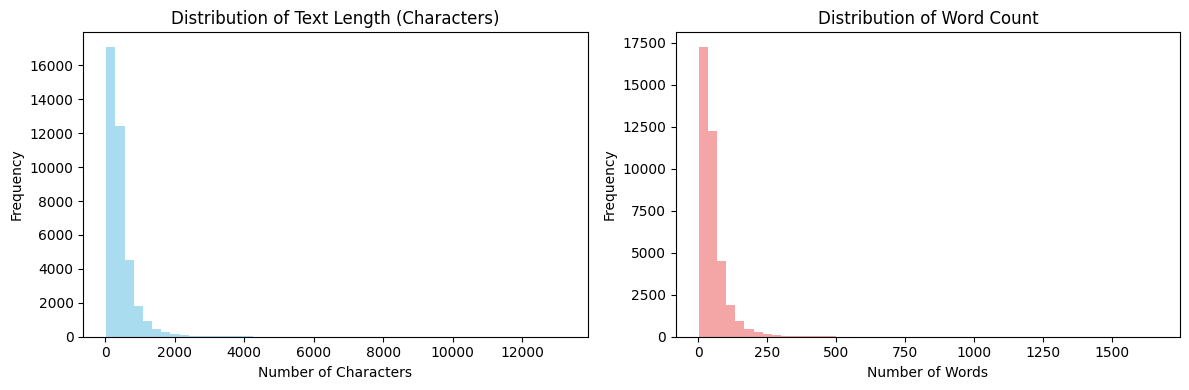

In [ ]:
print("\n" + "="*50)
print("📏 TEXT LENGTH ANALYSIS")
print("="*50)

df['text_length'] = df['cleaned_text'].str.len()
df['word_count'] = df['cleaned_text'].str.split().str.len()

print(f"📊 Text Statistics:")
print(f"   - Average text length: {df['text_length'].mean():.0f} characters")
print(f"   - Average word count: {df['word_count'].mean():.0f} words")
print(f"   - Min word count: {df['word_count'].min()}")
print(f"   - Max word count: {df['word_count'].max()}")

# Plot text length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['word_count'], bins=50, alpha=0.7, color='lightcoral')
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**SAMPLE DATA FOR CLUSTERING**


In [ ]:
print("\n" + "="*50)
print("🎯 PREPARE DATA FOR CLUSTERING")
print("="*50)

# Atau gunakan semua data
df_sample = df.copy()
print(f"📊 Using all {len(df_sample):,} hadits")

# Prepare documents for clustering
documents = df_sample['cleaned_text'].tolist()

print(f"✅ Documents prepared for clustering!")
print(f"📋 Total documents: {len(documents):,}")
print(f"📄 First document: {documents[0][:150]}...")


🎯 PREPARE DATA FOR CLUSTERING
📊 Using all 38,100 hadits
✅ Documents prepared for clustering!
📋 Total documents: 38,100
📄 First document: bahwasanya nabi shallallahu 'alaihi wasallam hendak pergi buang hajat, menjauh....


**SAVE PREPROCESSED DATA**


In [ ]:
print("\n" + "="*50)
print("💾 SAVING PREPROCESSED DATA")
print("="*50)

df_sample.to_csv('hadits_preprocessed.csv', index=False)
print(f"✅ Preprocessed data saved as 'hadits_preprocessed.csv'")

print("\n" + "="*50)
print("🎉 DATA PREPARATION COMPLETED!")
print("="*50)
print(f"📊 Summary:")
print(f"   - Original hadits: {df.shape[0]:,}")
print(f"   - After cleaning: {len(df_sample):,}")
print(f"   - Ready for clustering: ✅")
print(f"   - Next step: BERTopic model training")


💾 SAVING PREPROCESSED DATA
✅ Preprocessed data saved as 'hadits_preprocessed.csv'

🎉 DATA PREPARATION COMPLETED!
📊 Summary:
   - Original hadits: 38,100
   - After cleaning: 38,100
   - Ready for clustering: ✅
   - Next step: BERTopic model training


# 4. BERTOPIC MODEL TRAINING - CLUSTERING HADITS

1. SETUP SENTENCE TRANSFORMER


In [ ]:
print("🔧 Setting up Sentence Transformer...")
# Menggunakan model multilingual yang bagus untuk bahasa Indonesia
sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
print("✅ Sentence Transformer ready!")

🔧 Setting up Sentence Transformer...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Sentence Transformer ready!


2. SETUP UMAP (Dimensionality Reduction)


In [ ]:
print("🔧 Setting up UMAP...")
umap_model = UMAP(
    n_neighbors=15,      # Jumlah tetangga terdekat
    n_components=5,      # Dimensi output
    min_dist=0.0,        # Jarak minimum antar titik
    metric='cosine',     # Metrik jarak
    random_state=42
)
print("✅ UMAP ready!")

🔧 Setting up UMAP...
✅ UMAP ready!


3. SETUP HDBSCAN (Clustering Algorithm)


In [ ]:
print("🔧 Setting up HDBSCAN...")
hdbscan_model = HDBSCAN(
    min_cluster_size=15,     # Ukuran minimum cluster
    metric='euclidean',      # Metrik jarak
    cluster_selection_method='eom',  # Metode seleksi cluster
    prediction_data=True
)
print("✅ HDBSCAN ready!")

🔧 Setting up HDBSCAN...
✅ HDBSCAN ready!


4. SETUP VECTORIZER (untuk representasi topik)


In [ ]:
print("🔧 Setting up Vectorizer...")
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),      # Unigram dan bigram
    stop_words=None,         # Kita sudah remove stopwords
    min_df=2,                # Minimum document frequency
    max_df=0.9               # Maximum document frequency
)
print("✅ Vectorizer ready!")

🔧 Setting up Vectorizer...
✅ Vectorizer ready!


5. CREATE BERTOPIC MODEL


In [ ]:
print("\n" + "="*50)
print("🏗️ CREATING BERTOPIC MODEL")
print("="*50)

topic_model = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,  # Untuk mendapatkan probabilitas topik
    verbose=True
)

print("✅ BERTopic model created!")


🏗️ CREATING BERTOPIC MODEL
✅ BERTopic model created!


6. TRAIN THE MODEL


In [ ]:
print("\n" + "="*50)
print("🚀 TRAINING BERTOPIC MODEL")
print("="*50)
print("⏳ This may take several minutes...")

# Fit model pada dokumen
topics, probs = topic_model.fit_transform(documents)

print(f"✅ Model training completed!")
print(f"📊 Results:")
print(f"   - Number of topics found: {len(set(topics)) - (1 if -1 in topics else 0)}")
print(f"   - Documents with topics: {len([t for t in topics if t != -1])}")
print(f"   - Outliers (topic -1): {len([t for t in topics if t == -1])}")

2025-07-02 10:34:22,796 - BERTopic - Embedding - Transforming documents to embeddings.



🚀 TRAINING BERTOPIC MODEL
⏳ This may take several minutes...


Batches:   0%|          | 0/1191 [00:00<?, ?it/s]

2025-07-02 11:21:48,157 - BERTopic - Embedding - Completed ✓
2025-07-02 11:21:48,161 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-02 11:23:10,472 - BERTopic - Dimensionality - Completed ✓
2025-07-02 11:23:10,474 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-02 11:28:26,091 - BERTopic - Cluster - Completed ✓
2025-07-02 11:28:26,122 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-02 11:28:32,321 - BERTopic - Representation - Completed ✓


✅ Model training completed!
📊 Results:
   - Number of topics found: 300
   - Documents with topics: 17671
   - Outliers (topic -1): 20429


7. ANALYZE RESULTS


In [ ]:
print("\n" + "="*50)
print("📈 TOPIC ANALYSIS")
print("="*50)

# Topic frequency
topic_freq = topic_model.get_topic_freq()
print(f"📊 Top 10 topics by frequency:")
print(topic_freq.head(10))

# Topic information
topic_info = topic_model.get_topic_info()
print(f"\n📋 Topic information:")
print(topic_info.head())



📈 TOPIC ANALYSIS
📊 Top 10 topics by frequency:
    Topic  Count
0      -1  20429
7       0   1124
10      1    511
22      2    489
35      3    450
77      4    396
27      5    362
9       6    337
45      7    330
41      8    262

📋 Topic information:
   Topic  Count                                               Name  \
0     -1  20429                             -1_allah_kalian_al_ada   
1      0   1124                     0_matahari_malam_shalat_rakaat   
2      1    511                   1_rambut_rambutnya_mencukur_bulu   
3      2    489  2_mengangkat_kedua_mengangkat kedua_kedua tang...   
4      3    450                        3_makanan_makan_daging_roti   

                                      Representation  \
0  [allah, kalian, al, ada, menjawab, wahai, laki...   
1  [matahari, malam, shalat, rakaat, tidur, subuh...   
2  [rambut, rambutnya, mencukur, bulu, kumis, mem...   
3  [mengangkat, kedua, mengangkat kedua, kedua ta...   
4  [makanan, makan, daging, roti, memakann

8. DISPLAY TOP TOPICS


In [ ]:
print("\n" + "="*50)
print("🏷️ TOP TOPICS DETAILS")
print("="*50)

for topic_id in range(min(5, len(topic_freq))):  # Show top 5 topics
    if topic_id == 0 and -1 in topics:  # Skip outlier topic
        continue

    topic_words = topic_model.get_topic(topic_id)
    print(f"\n📍 Topic {topic_id}:")
    print(f"   Words: {', '.join([word for word, score in topic_words[:10]])}")

    # Show sample documents from this topic
    topic_docs_idx = [i for i, t in enumerate(topics) if t == topic_id]
    sample_docs = topic_docs_idx[:3]  # Take 3 sample documents

    print(f"   Sample hadits:")
    for i, doc_idx in enumerate(sample_docs):
        print(f"   {i+1}. {documents[doc_idx][:100]}...")


🏷️ TOP TOPICS DETAILS

📍 Topic 1:
   Words: rambut, rambutnya, mencukur, bulu, kumis, memotong, jenggot, memendekkan, memotong kuku, mencukur rambut
   Sample hadits:
   1. ibnu abdurrahman, berkata; pernah bertemu nabi shallallahu 'alaihi wasallam sebagaimana hurairah ber...
   2. berkata; rasulullah shallallahu 'alaihi wasallam bersabda: "sepuluh perkara termasuk fithrah: memoto...
   3. berdua berkata; bahwasanya rasulullah shallallahu 'alaihi wasallam pernah berwudhu di sisinya, mengu...

📍 Topic 2:
   Words: mengangkat, kedua, mengangkat kedua, kedua tangannya, tangannya, tangan, meletakkan, jari, sujud, rukuk
   Sample hadits:
   1. berkata; "tanganku tangan rasulullah shallallahu 'alaihi wasallam saling bergantian berwudhu satu be...
   2. berkata; pernah melihat rasulullah shallallahu 'alaihi wasallam berwudhu, menggosok jari-jari kedua ...
   3. berkata; pernah bertanya nabi shallallahu 'alaihi wasallam tayammum, memerintahkanku menepukkan satu...

📍 Topic 3:
   Words: makana

9. SAVE RESULTS


In [ ]:
# Pastikan library ini sudah di-import di bagian atas skrip Anda
import shutil
import os

print("\n" + "="*50)
print("💾 SAVING RESULTS & ZIPPING MODEL")
print("="*50)

# Tambahkan hasil topic modeling ke dalam dataframe
df_sample['topic'] = topics
df_sample['topic_probability'] = probs.max(axis=1) if probs is not None else None

# Simpan dataframe yang sudah ada topiknya ke file CSV
df_sample.to_csv('hadits_with_topics.csv', index=False)
print("✅ Hasil analisis disimpan ke 'hadits_with_topics.csv'")

# --- Langkah 1: Simpan model ke sebuah FOLDER terlebih dahulu ---
# Ini adalah langkah yang wajib, karena model tidak bisa langsung disimpan ke zip.
model_folder_path = "bertopic_hadits_model"
print(f"✅ Menyimpan model ke folder sementara '{model_folder_path}'...")
topic_model.save(model_folder_path, save_embedding_model=False)
print("✅ Folder model berhasil disimpan!")

# Kompres FOLDER tersebut menjadi satu file .ZIP ---
# Nama file zip yang akan dihasilkan
output_zip_filename = 'bertopic_hadits_model' # Ini akan membuat 'bertopic_hadits_model.zip'
print(f"📦 Mengompres folder model menjadi '{output_zip_filename}.zip'...")

# Cek apakah folder sumber ada sebelum mencoba men-zip
if os.path.exists(model_folder_path):
    # Membuat arsip zip dari folder
    shutil.make_archive(
        base_name=output_zip_filename,  # Nama file output
        format='zip',                   # Format arsip
        root_dir='.',                   # Direktori awal
        base_dir=model_folder_path      # Folder yang akan di-zip
    )
    print(f"✅ Berhasil! Output akhir Anda adalah file '{output_zip_filename}.zip'.")


💾 SAVING RESULTS & ZIPPING MODEL


2025-07-02 12:38:08,763 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✅ Hasil analisis disimpan ke 'hadits_with_topics.csv'
✅ Menyimpan model ke folder sementara 'bertopic_hadits_model'...
✅ Folder model berhasil disimpan!
📦 Mengompres folder model menjadi 'bertopic_hadits_model.zip'...
✅ Berhasil! Output akhir Anda adalah file 'bertopic_hadits_model.zip'.
🗑️ Menghapus folder sementara 'bertopic_hadits_model'...


NotADirectoryError: [Errno 20] Not a directory: 'bertopic_hadits_model'

10. BASIC VISUALIZATION



📊 BASIC VISUALIZATION


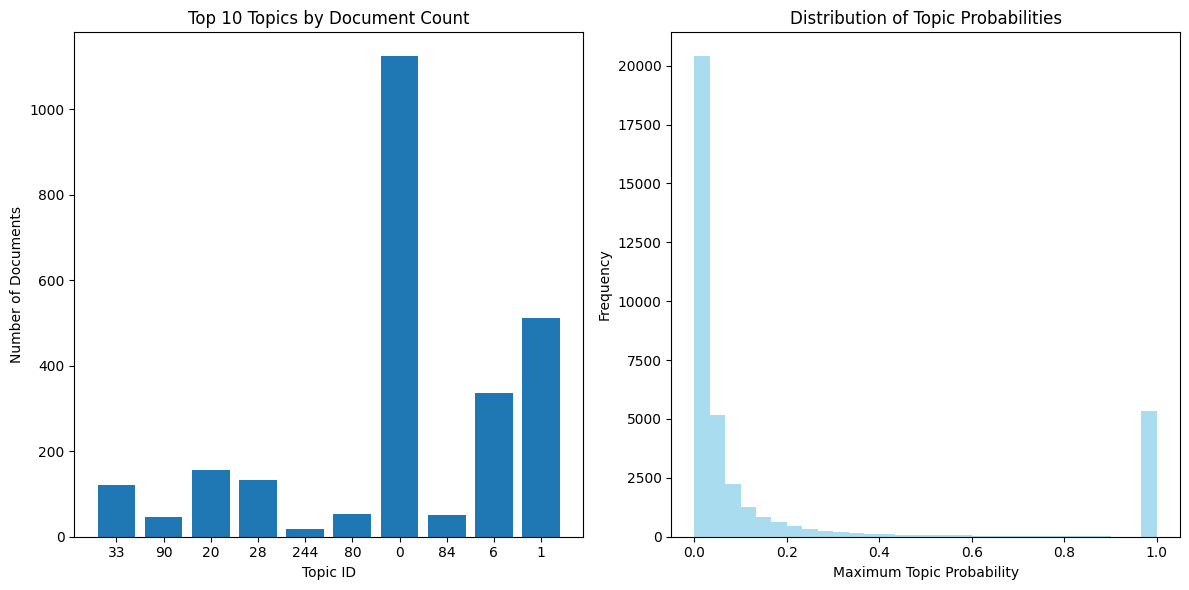


🎉 BERTOPIC TRAINING COMPLETED!
📊 Summary:
   - Topics discovered: 300
   - Model saved: ✅
   - Results saved: ✅
   - Ready for analysis: ✅


In [ ]:
print("\n" + "="*50)
print("📊 BASIC VISUALIZATION")
print("="*50)

# Topic distribution
plt.figure(figsize=(12, 6))

# Topic frequency plot
plt.subplot(1, 2, 1)
topic_counts = Counter(topics)
topics_list = list(topic_counts.keys())
counts_list = list(topic_counts.values())

# Remove outlier topic for better visualization
if -1 in topics_list:
    outlier_idx = topics_list.index(-1)
    topics_list.pop(outlier_idx)
    counts_list.pop(outlier_idx)

plt.bar(range(len(topics_list[:10])), counts_list[:10])
plt.title('Top 10 Topics by Document Count')
plt.xlabel('Topic ID')
plt.ylabel('Number of Documents')
plt.xticks(range(len(topics_list[:10])), topics_list[:10])

# Topic probability distribution
if probs is not None:
    plt.subplot(1, 2, 2)
    max_probs = probs.max(axis=1)
    plt.hist(max_probs, bins=30, alpha=0.7, color='skyblue')
    plt.title('Distribution of Topic Probabilities')
    plt.xlabel('Maximum Topic Probability')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("🎉 BERTOPIC TRAINING COMPLETED!")
print("="*50)
print("📊 Summary:")
print(f"   - Topics discovered: {len(set(topics)) - (1 if -1 in topics else 0)}")
print(f"   - Model saved: ✅")
print(f"   - Results saved: ✅")
print(f"   - Ready for analysis: ✅")

# ALISIS DAN VISUALISASI HASIL CLUSTERING HADITS

In [ ]:
# Load model dan data jika belum ada
try:
    print(f"📊 Using existing model and data")
except:
    print("📂 Loading saved model and data...")
    topic_model = BERTopic.load("bertopic_hadits_model")
    df_sample = pd.read_csv('hadits_with_topics.csv')
    documents = df_sample['cleaned_text'].tolist()
    topics = df_sample['topic'].tolist()
    print("✅ Model and data loaded!")

print("\n" + "="*50)
print("🔍 DETAILED TOPIC ANALYSIS")
print("="*50)

📊 Using existing model and data

🔍 DETAILED TOPIC ANALYSIS


1. TOPIC STATISTICS


In [ ]:
print("📊 Topic Statistics:")
topic_counts = df_sample['topic'].value_counts().sort_index()
print(f"   - Total topics: {len(topic_counts)}")
print(f"   - Largest topic: {topic_counts.max()} documents")
print(f"   - Smallest topic: {topic_counts.min()} documents")
print(f"   - Average topic size: {topic_counts.mean():.1f} documents")

if -1 in topic_counts.index:
    print(f"   - Outliers (ungrouped): {topic_counts[-1]} documents ({topic_counts[-1]/len(df_sample)*100:.1f}%)")

📊 Topic Statistics:
   - Total topics: 301
   - Largest topic: 20429 documents
   - Smallest topic: 15 documents
   - Average topic size: 126.6 documents
   - Outliers (ungrouped): 20429 documents (53.6%)


2. TOPIC LABELS (Manual Interpretation)


In [ ]:
def interpret_topic_theme(topic_words):
    """
    Fungsi untuk menginterpretasi tema topik berdasarkan kata-kata kunci
    """
    words = [word for word, score in topic_words[:10]]
    word_str = ' '.join(words)

    # Interpretasi berdasarkan kata kunci
    if any(word in word_str for word in ['sholat', 'salat', 'rukuk', 'sujud', 'imam']):
        return "Sholat dan Ibadah"
    elif any(word in word_str for word in ['rasul', 'allah', 'nabi', 'muhammad']):
        return "Rasulullah dan Kenabian"
    elif any(word in word_str for word in ['nikah', 'isteri', 'suami', 'keluarga']):
        return "Pernikahan dan Keluarga"
    elif any(word in word_str for word in ['makanan', 'makan', 'minum', 'halal', 'haram']):
        return "Makanan dan Minuman"
    elif any(word in word_str for word in ['jihad', 'perang', 'musuh', 'tentara']):
        return "Jihad dan Perang"
    elif any(word in word_str for word in ['zakat', 'sedekah', 'harta', 'miskin']):
        return "Zakat dan Sedekah"
    elif any(word in word_str for word in ['puasa', 'ramadhan', 'buka', 'sahur']):
        return "Puasa dan Ramadhan"
    elif any(word in word_str for word in ['haji', 'umrah', 'makkah', 'madinah']):
        return "Haji dan Umrah"
    elif any(word in word_str for word in ['ilmu', 'belajar', 'guru', 'murid']):
        return "Ilmu dan Pendidikan"
    elif any(word in word_str for word in ['sakit', 'obat', 'dokter', 'sehat']):
        return "Kesehatan dan Pengobatan"
    else:
        return "Tema Umum"

3. ANALYZE EACH TOPIC IN DETAIL


In [ ]:
print("\n" + "="*50)
print("📋 DETAILED TOPIC BREAKDOWN")
print("="*50)

topic_analysis = []

for topic_id in sorted(set(topics)):
    if topic_id == -1:  # Skip outliers
        continue

    # Get topic information
    topic_words = topic_model.get_topic(topic_id)
    topic_size = topic_counts[topic_id]

    # Interpret theme
    theme = interpret_topic_theme(topic_words)

    # Get sample documents
    topic_docs_idx = [i for i, t in enumerate(topics) if t == topic_id]
    sample_docs = [documents[i] for i in topic_docs_idx[:3]]

    topic_analysis.append({
        'topic_id': topic_id,
        'theme': theme,
        'size': topic_size,
        'percentage': (topic_size / len(df_sample)) * 100,
        'top_words': [word for word, score in topic_words[:10]],
        'sample_docs': sample_docs
    })

# Sort by size
topic_analysis.sort(key=lambda x: x['size'], reverse=True)

# Display analysis
for i, analysis in enumerate(topic_analysis[:10]):  # Show top 10 topics
    print(f"\n🏷️ Topic {analysis['topic_id']}: {analysis['theme']}")
    print(f"   📊 Size: {analysis['size']} dokumen ({analysis['percentage']:.1f}%)")
    print(f"   🔑 Kata kunci: {', '.join(analysis['top_words'])}")
    print(f"   📄 Contoh hadits:")
    for j, doc in enumerate(analysis['sample_docs']):
        print(f"      {j+1}. {doc[:120]}...")


📋 DETAILED TOPIC BREAKDOWN

🏷️ Topic 0: Tema Umum
   📊 Size: 1124 dokumen (3.0%)
   🔑 Kata kunci: matahari, malam, shalat, rakaat, tidur, subuh, terbit, gerhana, dua rakaat, bangun
   📄 Contoh hadits:
      1. bahwasanya berkata; nabi shallallahu 'alaihi wasallam memiliki bejana pelepah kurma (yang letakkan) di ranjangnya, gunak...
      2. bahwasanya rasulullah shallallahu 'alaihi wasallam bangun di malam hari, menggosok (gigi-gigi) mulutnya siwak....
      3. bahwasanya nabi shallallahu 'alaihi wasallam tidaklah bangun tidurnya baik malam maupun siang, kecuali bersiwak dahulu s...

🏷️ Topic 1: Tema Umum
   📊 Size: 511 dokumen (1.3%)
   🔑 Kata kunci: rambut, rambutnya, mencukur, bulu, kumis, memotong, jenggot, memendekkan, memotong kuku, mencukur rambut
   📄 Contoh hadits:
      1. ibnu abdurrahman, berkata; pernah bertemu nabi shallallahu 'alaihi wasallam sebagaimana hurairah bersahabat beliau, berk...
      2. berkata; rasulullah shallallahu 'alaihi wasallam bersabda: "sepuluh perk

4. CREATE TOPIC SUMMARY TABLE


In [ ]:
print("\n" + "="*50)
print("📊 TOPIC SUMMARY TABLE")
print("="*50)

summary_df = pd.DataFrame(topic_analysis)
summary_df = summary_df[['topic_id', 'theme', 'size', 'percentage']].head(15)
print(summary_df.to_string(index=False))


📊 TOPIC SUMMARY TABLE
 topic_id               theme  size  percentage
        0           Tema Umum  1124    2.950131
        1           Tema Umum   511    1.341207
        2   Sholat dan Ibadah   489    1.283465
        3 Makanan dan Minuman   450    1.181102
        4           Tema Umum   396    1.039370
        5   Sholat dan Ibadah   362    0.950131
        6           Tema Umum   337    0.884514
        7           Tema Umum   330    0.866142
        8           Tema Umum   262    0.687664
        9   Sholat dan Ibadah   248    0.650919
       10   Zakat dan Sedekah   227    0.595801
       11           Tema Umum   215    0.564304
       12 Makanan dan Minuman   200    0.524934
       13           Tema Umum   190    0.498688
       14    Jihad dan Perang   189    0.496063


# 5. ADVANCED VISUALIZATIONS

1. Horizontal bar chart of top topics


Text(0.5, 0, 'Number of Documents')

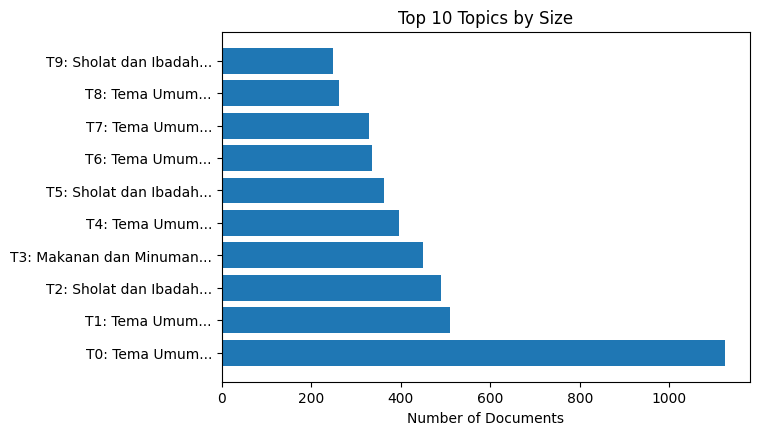

In [ ]:
# Topic size visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
top_topics = summary_df.head(10)
plt.barh(range(len(top_topics)), top_topics['size'])
plt.yticks(range(len(top_topics)), [f"T{row['topic_id']}: {row['theme'][:20]}..."
                                   for _, row in top_topics.iterrows()])
plt.title('Top 10 Topics by Size')
plt.xlabel('Number of Documents')

2. Topic percentage pie chart


Text(0.5, 1.0, 'Topic Distribution (Top 5)')

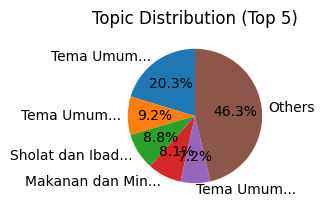

In [ ]:
plt.subplot(2, 2, 2)
top_5_topics = summary_df.head(5)
other_size = summary_df[5:]['size'].sum() if len(summary_df) > 5 else 0
sizes = list(top_5_topics['size']) + ([other_size] if other_size > 0 else [])
labels = [f"{row['theme'][:15]}..." for _, row in top_5_topics.iterrows()] + (['Others'] if other_size > 0 else [])
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Topic Distribution (Top 5)')

3. Topic size distribution


Text(0, 0.5, 'Number of Topics')

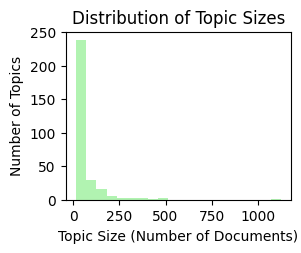

In [ ]:
plt.subplot(2, 2, 3)
plt.hist([analysis['size'] for analysis in topic_analysis], bins=20, alpha=0.7, color='lightgreen')
plt.title('Distribution of Topic Sizes')
plt.xlabel('Topic Size (Number of Documents)')
plt.ylabel('Number of Topics')

4. Word cloud preparation (top words from all topics)


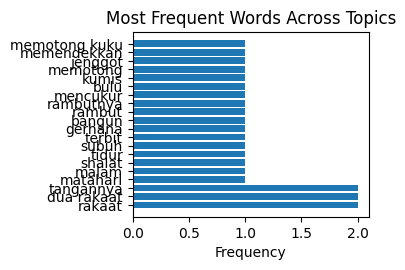

In [ ]:
plt.subplot(2, 2, 4)
all_words = []
for analysis in topic_analysis[:10]:
    all_words.extend(analysis['top_words'])
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

words, freqs = zip(*most_common)
plt.barh(range(len(words)), freqs)
plt.yticks(range(len(words)), words)
plt.title('Most Frequent Words Across Topics')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

# 6. SEARCH FUNCTION


In [ ]:
print("\n" + "="*50)
print("🔍 SEARCH FUNCTION")
print("="*50)

def search_hadits_by_topic(query, top_k=5):
    """
    Fungsi untuk mencari hadits berdasarkan query
    """
    print(f"🔍 Searching for: '{query}'")

    # Find similar topics
    query_embedding = topic_model._extract_embeddings([query])
    similarities = []

    for topic_id in set(topics):
        if topic_id == -1:
            continue

        topic_words = topic_model.get_topic(topic_id)
        topic_text = ' '.join([word for word, score in topic_words[:20]])
        topic_embedding = topic_model._extract_embeddings([topic_text])

        # Calculate cosine similarity
        similarity = np.dot(query_embedding[0], topic_embedding[0]) / (
            np.linalg.norm(query_embedding[0]) * np.linalg.norm(topic_embedding[0])
        )
        similarities.append((topic_id, similarity))

    # Sort by similarity
    similarities.sort(key=lambda x: x[1], reverse=True)

    print(f"\n📋 Most relevant topics:")
    for i, (topic_id, sim) in enumerate(similarities[:3]):
        topic_info = next(a for a in topic_analysis if a['topic_id'] == topic_id)
        print(f"{i+1}. Topic {topic_id}: {topic_info['theme']} (similarity: {sim:.3f})")

        # Show sample hadits from this topic
        topic_docs_idx = [j for j, t in enumerate(topics) if t == topic_id]
        sample_docs = topic_docs_idx[:top_k]

        print(f"   📄 Sample hadits:")
        for j, doc_idx in enumerate(sample_docs):
            print(f"   {j+1}. {documents[doc_idx][:100]}...")
        print()

# Example searches
print("🔍 Example searches:")
search_queries = ["sholat", "makanan", "keluarga"]

for query in search_queries:
    search_hadits_by_topic(query)
    print("-" * 30)


🔍 SEARCH FUNCTION
🔍 Example searches:
🔍 Searching for: 'sholat'

📋 Most relevant topics:
1. Topic 13: Tema Umum (similarity: 0.753)
   📄 Sample hadits:
   1. memarfu'kannya nabi shallallahu 'alaihi wasallam, bersabda: "kalau saja tidak memberatkan orang-oran...
   2. mengabarkan berkata; rasulullah shallallahu 'alaihi wasallam bersabda: "allah tidak menerima shalat ...
   3. berkata; rasulullah shallallahu 'alaihi wasallam bersabda: "kunci shalat bersuci, mengharamkannya (d...
   4. berkata; biasanya bilal setelah mengumandangkan adzan, menunggu sejenak, melihat nabi shallallahu 'a...
   5. berkata; iqamat shalat dikumandangkan, sementara rasulullah shallallahu alaihi wasallam berbiisik-bi...

2. Topic 125: Tema Umum (similarity: 0.747)
   📄 Sample hadits:
   1. kepadaku berkata; tatkala mendatangi sebagai tentara perang, uqbah amir menjadi gubernur mesir. meng...
   2. berkata; berkata; kepadaku berkata; seorang laki-laki bernadzar zaman rasulullah shallallahu 'alaihi...
   3. yaitu 

# 7. SAVE FINAL RESULTS


In [ ]:
print("\n" + "="*50)
print("💾 SAVING FINAL RESULTS")
print("="*50)

# Add interpreted themes to dataframe
theme_mapping = {analysis['topic_id']: analysis['theme'] for analysis in topic_analysis}
theme_mapping[-1] = "Uncategorized"  # For outliers

df_sample['topic_theme'] = df_sample['topic'].map(theme_mapping)

# Save final results
df_sample.to_csv('hadits_final_results.csv', index=False)
print("✅ Final results saved as 'hadits_final_results.csv'")

# Save topic analysis
pd.DataFrame(topic_analysis).to_csv('topic_analysis_summary.csv', index=False)
print("✅ Topic analysis saved as 'topic_analysis_summary.csv'")

print("\n" + "="*50)
print("🎉 CLUSTERING ANALYSIS COMPLETED!")
print("="*50)
print("📊 Final Summary:")
print(f"   - Total hadits processed: {len(df_sample):,}")
print(f"   - Topics discovered: {len(topic_analysis)}")
print(f"   - Largest topic: {max(analysis['size'] for analysis in topic_analysis)} hadits")
print(f"   - Analysis saved: ✅")
print(f"   - Search function: ✅")
print(f"   - Ready for deployment: ✅")


💾 SAVING FINAL RESULTS
✅ Final results saved as 'hadits_final_results.csv'
✅ Topic analysis saved as 'topic_analysis_summary.csv'

🎉 CLUSTERING ANALYSIS COMPLETED!
📊 Final Summary:
   - Total hadits processed: 38,100
   - Topics discovered: 300
   - Largest topic: 1124 hadits
   - Analysis saved: ✅
   - Search function: ✅
   - Ready for deployment: ✅


In [ ]:
!pip freeze > requirements.txt